# 2nd Assignment: Sentiment Analysis

---
>Vasileios Galanos <br>
>Registration Number p3351902 <br>
>vgalanos@aueb.gr

This notebook accompanied with the report given provides our solution to the 2nd assignment of the Text Analytics course at Data Science MSc at AUEB. <br>

#### Install required packages


In [0]:
%%capture
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib

#### Import all libraries for later use

In [7]:
from pprint import pprint
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import WordPunctTokenizer
from google.colab import files
from sklearn.datasets import load_files
from bs4 import BeautifulSoup 
import re
import matplotlib.pyplot as plt
import nltk
import re
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from nltk.corpus import stopwords
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import recall_score,f1_score
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD
import time

nltk.download('wordnet',quiet=True)
nltk.download('stopwords',quiet=True)

True

#### Download a sentiment analysis dataset

In [9]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip "trainingandtestdata.zip"

--2020-05-27 13:44:28--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-05-27 13:44:29--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  21.1MB/s    in 4.5s    

2020-05-27 13:44:34 (17.2 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


#### Load Data from csv file

In [10]:
pd.set_option('max_colwidth', 800)
cols = ['sentiment','id','date','query_string','user','text']
tweets_final = pd.read_csv("/content/training.1600000.processed.noemoticon.csv",
                 encoding = "ISO-8859-1", header=None, names=cols)
tweets_final.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


#### Remove useless columns

In [11]:
tweets_final.drop(['id','date','query_string','user'],axis=1,inplace=True)
tweets_final.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


#### Get a count of data to see that there are no neutral tweets

In [12]:
tweets_final.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

#### Data preprocessing/cleaning/preparation

In [0]:
tok = WordPunctTokenizer()
stemmer = WordNetLemmatizer()

#remove references
pat1 = r'@[A-Za-z0-9]+'
#remove links
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat1 = r'|'.join((pat1, pat2))

# remove all single characters
pat3 = r'\s+[a-zA-Z]\s+'
#remove hashtags, numbers
pat4 = r'\^[a-zA-Z!]\s+' 
# Substituting multiple spaces with single space
pat5 = r'\s+'
combined_pat2 = r'|'.join((pat4, pat5))

def tweet_cleaner(text):
    #remove html related tags
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat1, '', souped)
    stripped = re.sub(combined_pat2, ' ', stripped)

    try:
        #replace possibe faulty characters
        clean = stripped.replace(u"\ufffd", "?")
    except:
        clean = stripped
    #keep only letters
    letters_only = re.sub("[^a-zA-Z!]", " ", clean)
    lower_case = letters_only.lower()
    lower_case = lower_case.split()
    #lemmatize
    lower_case = [stemmer.lemmatize(word) for word in lower_case]
    lower_case = ' '.join(lower_case)
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [14]:
# set N for sample size
N = 100000

start_time = time.time()

# shuffle
tweets_final = tweets_final.sample(frac=1)

# get a subspace of the original dataset and preproccess it
tweets_final = tweets_final[:N]
tweets_final['text'] = tweets_final['text'].apply(lambda x : tweet_cleaner(x))

elapsed_time = time.time() - start_time

print('Time passed %0.0f seconds' % elapsed_time)
tweets_final.head(4)

Time passed 38 seconds


,sentiment,text
1220597,4,excellent good time to buy one great pricing co tax benefit hand me down to the kid in month
1385323,4,hey ! you promised you d tweet me tonight hope to talk to you again soon
1225205,4,who is this faceless avenger with good tidings !
1066567,4,they say love hurt lol better to learn it young


#### Change labels to (0,1)


In [0]:
tweets_final.loc[tweets_final['sentiment'] == 4, "sentiment"] = 1

#### Train, Dev & Test split

In [16]:
total_length = len(tweets_final)
train_set = tweets_final[0:int((total_length*7)/10)]
print(train_set[0:3])
dev_set = tweets_final[int((total_length*7)/10)+1:int((total_length*9)/10)]
print(dev_set[0:3])
test_set = tweets_final[int((total_length*9)/10)+1:total_length]
print(test_set[0:3])

         sentiment                                                                                          text
1220597          1  excellent good time to buy one great pricing co tax benefit hand me down to the kid in month
1385323          1                      hey ! you promised you d tweet me tonight hope to talk to you again soon
1225205          1                                              who is this faceless avenger with good tidings !
         sentiment                                                                     text
172019           0     is making cupcake and say i can t have any kelli you re a bad sister
1405287          1                                                     you are a crackup !!
630560           0  i tried to give you up but i m addicted muse time is running out iphone
         sentiment                                                                                                                                   text
424912           0        

#### Some statistics on the dataset


In [17]:
avg_doc_len = tweets_final.groupby('sentiment').text.apply(lambda x: x.str.split().str.len().mean())
print("Average document length per sentiment is: ")
print(avg_doc_len)

Average document length per sentiment is: 
sentiment
0    13.804990
1    12.851547
Name: text, dtype: float64


In [0]:
print("The total number of documents is: ", total_length, ".")

The total number of documents is:  100000 .


In [18]:
print("Training set contains: ", len(train_set)," documents.")
print("Developement set contains: ", len(dev_set)," documents.")
print("Test set contains: ", len(test_set)," documents.")

Training set contains:  70000  documents.
Developement set contains:  19999  documents.
Test set contains:  9999  documents.


#### Macro Average - Precision, Recall & F1 scores

In [0]:
def get_scores(y_true, y_scores, threshold):
  """
  input:
    y_true: array with gound truth
    y_scores: array-like, shape = [n_samples, n_classes], the probability of the sample for each class in the model
    threshold: classification threshold in order to classify to positive class

  output:
    precision: dictionary with scores for all classes + macro precision
    recall: dictionary with scores for all classes + macro recall
    f1: dictionary with scores for all classes + macro f1

  """
  N_labels = y_scores.shape[1] # number of classes
  
  precision = {}
  recall = {}
  f1 = {}

  for label in range(N_labels):
    
    # create array with predictions based on which class is considered positive and a threshold
    y_pred = np.array([int(label if elem >= threshold else 1-label) for elem in y_scores[:,label]])
  
    # calculate True Positive, False Positive, True Negative, False Negative
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
      if y_true[i]==y_pred[i]==label:
        TP += 1
      if y_pred[i]==label and y_true[i]!=y_pred[i]:
        FP += 1
      if y_pred[i]==1-label and y_true[i]!=y_pred[i]:
        FN += 1
    precision[label] = 0 if (TP + FP) == 0 else TP / (TP + FP) 
    recall[label] = 0 if (TP + FN) == 0 else TP / (TP + FN)
    f1[label] = 0 if (precision[label] + recall[label]) ==0 else 2 * (precision[label] * recall[label]) / (precision[label] + recall[label]) 

  precision['macro'] = sum(precision.values())/N_labels
  recall['macro'] = sum(recall.values())/N_labels
  f1['macro'] = sum(f1.values())/N_labels
  
  return precision, recall, f1

def print_scores(estimator, X, y_true, threshold):
  y_pred = estimator.predict_proba(X)
  prec_dict, rec_dict, f1_dict = get_scores(y_true, y_pred, threshold)
  scores_df = pd.DataFrame.from_dict({'precision': prec_dict, 'recall': rec_dict, 'f1': f1_dict})
  print(tabulate(scores_df.round(3), headers='keys', tablefmt='psql'))


#### Baseline

In [22]:
def print_classifier_scores(estimator, est_name, X_train, y_train
                            ,X_dev, y_dev
                            ,X_test,y_test
                            , thres):

  print("{}- Train scores:".format(est_name))
  print_scores(estimator, X_train, y_train, thres)

  print("---------------------------------------------------------")
  print("{}- Dev scores:".format(est_name))
  print_scores(estimator, X_dev ,y_dev, thres)

  print("---------------------------------------------------------")
  print("{}- Test scores:".format(est_name))
  print_scores(estimator, X_test, y_test, thres)

# Create pipeline
base_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1, 2)
                             ,max_features = 5000
                             ,sublinear_tf=True
                             ,stop_words=stopwords.words('english')
    )),
    ('clf',  DummyClassifier(strategy='most_frequent'))
    ])

# fit on training set and print scores
base_pipeline.fit(train_set.text, train_set.sentiment.to_list())



print_classifier_scores(base_pipeline, 'Baseline', train_set.text, train_set.sentiment.to_list()
  , dev_set.text, dev_set.sentiment.to_list()
  , test_set.text, test_set.sentiment.to_list(),0.5)


Baseline- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.501 |      1   | 0.668 |
| 1     |       0     |      0   | 0     |
| macro |       0.251 |      0.5 | 0.334 |
+-------+-------------+----------+-------+
---------------------------------------------------------
Baseline- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.499 |      1   | 0.666 |
| 1     |       0     |      0   | 0     |
| macro |       0.25  |      0.5 | 0.333 |
+-------+-------------+----------+-------+
---------------------------------------------------------
Baseline- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.495 |      1   | 0.662 |
| 1     |       0     |      0   | 0     

#### SGD Logistic Regression

Pipeline + Gridsearch for SGD


In [0]:
lr_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'), max_features=5000)),
    ('clf', SGDClassifier(loss="log", max_iter=5000))
    ])

grid_params = {
    'tfidf_vectorizer__ngram_range': [(1,1),(1,2),(1,3)],  
    'tfidf_vectorizer__sublinear_tf': [True,False],
    "clf__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "clf__penalty" : ["l2", "l1", "none"],
}
# start timing
start_time = time.time()

grid_sgd_clf = RandomizedSearchCV(lr_pipeline, grid_params, scoring='f1_macro',n_jobs=-1, random_state=94)

# perform gridsearch on both training and dev set with 5-fold cross validation and save the best model
grid_sgd_clf.fit(np.concatenate((train_set.text, dev_set.text), axis=0)
                ,train_set.sentiment.tolist() + dev_set.sentiment.tolist()
                )

elapsed_time = time.time() - start_time
print('After {:.0f} seconds'.format(elapsed_time), ' Random GridSearch found: ')
print("Best Score: {:.3f}" .format(grid_sgd_clf.best_score_))
print("Best Params: ", grid_sgd_clf.best_params_)

# get best estimator
sgd_pipeline = grid_sgd_clf.best_estimator_

After 131 seconds  Random GridSearch found: 
Best Score: 0.754
Best Params:  {'tfidf_vectorizer__sublinear_tf': False, 'tfidf_vectorizer__ngram_range': (1, 3), 'clf__penalty': 'l2', 'clf__alpha': 0.0001}


In [0]:
start_time = time.time()
sgd_pipeline.fit(train_set.text, train_set.sentiment.to_list())

elapsed_time = time.time() - start_time
print('Fitting ended after {:.0f} seconds.'.format(elapsed_time))

print_classifier_scores(sgd_pipeline, 'SGD classifier', train_set.text, train_set.sentiment.to_list()
  , dev_set.text, dev_set.sentiment.to_list()
  , test_set.text, test_set.sentiment.to_list(),0.5)

Fitting ended after 5 seconds.
SGD classifier- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.78  |    0.757 | 0.768 |
| 1     |       0.762 |    0.785 | 0.773 |
| macro |       0.771 |    0.771 | 0.771 |
+-------+-------------+----------+-------+
---------------------------------------------------------
SGD classifier- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.76  |    0.74  | 0.75  |
| 1     |       0.748 |    0.767 | 0.757 |
| macro |       0.754 |    0.754 | 0.754 |
+-------+-------------+----------+-------+
---------------------------------------------------------
SGD classifier- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.767 |    0.74  | 

#### Random forest classifier

Pipeline + Gridsearch for Random Forest

In [0]:
rf_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'), max_features=5000)),
    ('clf', RandomForestClassifier(random_state=94))
    ])

grid_params = {
    'tfidf_vectorizer__ngram_range': [(1,1),(1,2),(1,3)],  
    'tfidf_vectorizer__sublinear_tf': [True,False],
    'clf__n_estimators': [100, 500, 1000, 2000],
    'clf__max_depth': [1, 2, 3, 4]
}

grid_rf_clf = RandomizedSearchCV(rf_pipeline, grid_params, scoring='f1_macro', n_jobs=-1)

start_time = time.time()

grid_rf_clf.fit(np.concatenate((train_set.text, dev_set.text), axis=0)
                ,train_set.sentiment.tolist() + dev_set.sentiment.tolist()
                )

elapsed_time = time.time() - start_time
print('After {:.0f} seconds'.format(elapsed_time), ' Random GridSearch found: ')
print("Best Score: {:.3f}" .format(grid_rf_clf.best_score_))
print("Best Params: ", grid_rf_clf.best_params_)

rf_pipeline = grid_rf_clf.best_estimator_

After 622 seconds  Random GridSearch found: 
Best Score: 0.711
Best Params:  {'tfidf_vectorizer__sublinear_tf': False, 'tfidf_vectorizer__ngram_range': (1, 3), 'clf__n_estimators': 1000, 'clf__max_depth': 3}


In [0]:
start_time = time.time()
rf_pipeline.fit(train_set.text, train_set.sentiment.to_list())

elapsed_time = time.time() - start_time
print('Fitting ended after {:.0f} seconds.'.format(elapsed_time))

print_classifier_scores(rf_pipeline, 'Random Forest classifier', train_set.text, train_set.sentiment.to_list()
  , dev_set.text, dev_set.sentiment.to_list()
  , test_set.text, test_set.sentiment.to_list(),0.5)

Fitting ended after 16 seconds.
Random Forest classifier- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.625 |    0.882 | 0.731 |
| 1     |       0.797 |    0.466 | 0.588 |
| macro |       0.711 |    0.674 | 0.66  |
+-------+-------------+----------+-------+
---------------------------------------------------------
Random Forest classifier- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.617 |    0.876 | 0.724 |
| 1     |       0.789 |    0.459 | 0.58  |
| macro |       0.703 |    0.668 | 0.652 |
+-------+-------------+----------+-------+
---------------------------------------------------------
Random Forest classifier- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0 

#### Naive Bayes

In [0]:
nb_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'), max_features = 5000)),
    ('clf', MultinomialNB())
    ])

grid_params = {
    'tfidf_vectorizer__ngram_range': [(1,1),(1,2),(1,3)],  
    'tfidf_vectorizer__sublinear_tf': [True,False],
    "clf__alpha" : np.linspace(0, 1, 5)
}

start_time = time.time()

grid_nb_clf = RandomizedSearchCV(nb_pipeline, grid_params, scoring='f1_macro', n_jobs=-1)
grid_nb_clf.fit(np.concatenate((train_set.text, dev_set.text), axis=0)
                ,train_set.sentiment.tolist() + dev_set.sentiment.tolist()
                )
elapsed_time = time.time() - start_time
print('After {:.0f} seconds'.format(elapsed_time), ' Random GridSearch found: ')
print("Best Score: {:.3f}" .format(grid_nb_clf.best_score_))
print("Best Params: ", grid_nb_clf.best_params_)

nb_pipeline = grid_nb_clf.best_estimator_

After 134 seconds  Random GridSearch found: 
Best Score: 0.748
Best Params:  {'tfidf_vectorizer__sublinear_tf': True, 'tfidf_vectorizer__ngram_range': (1, 3), 'clf__alpha': 1.0}


In [0]:
start_time = time.time()
nb_pipeline.fit(train_set.text, train_set.sentiment.to_list())

elapsed_time = time.time() - start_time
print('Fitting ended after {:.0f} seconds.'.format(elapsed_time))

print_classifier_scores(nb_pipeline, 'Naive Bayes classifier', train_set.text, train_set.sentiment.to_list()
  , dev_set.text, dev_set.sentiment.to_list()
  , test_set.text, test_set.sentiment.to_list(),0.5)

Fitting ended after 5 seconds.
Naive Bayes classifier- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.766 |    0.786 | 0.776 |
| 1     |       0.778 |    0.758 | 0.768 |
| macro |       0.772 |    0.772 | 0.772 |
+-------+-------------+----------+-------+
---------------------------------------------------------
Naive Bayes classifier- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.743 |    0.762 | 0.753 |
| 1     |       0.758 |    0.738 | 0.748 |
| macro |       0.75  |    0.75  | 0.75  |
+-------+-------------+----------+-------+
---------------------------------------------------------
Naive Bayes classifier- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |  

#### Precision - Recall Curve


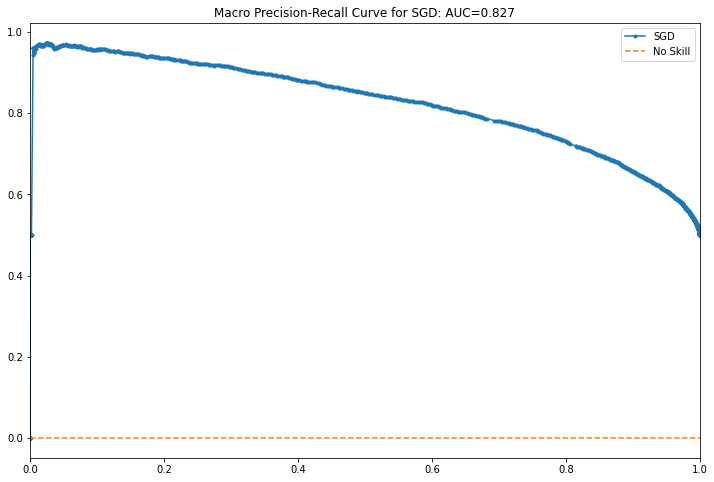

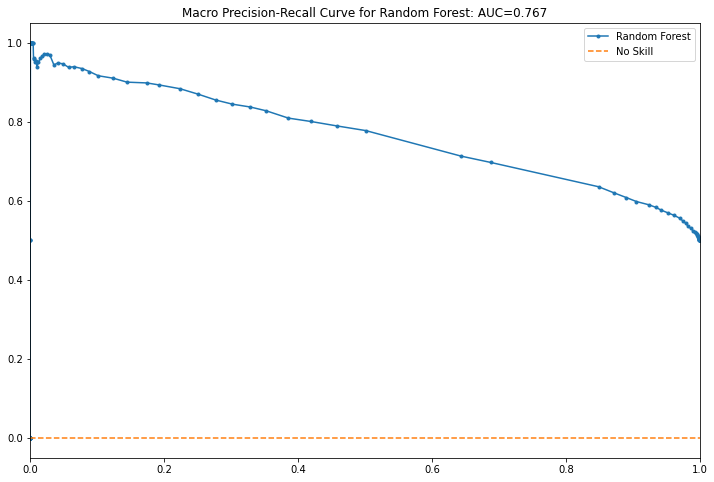

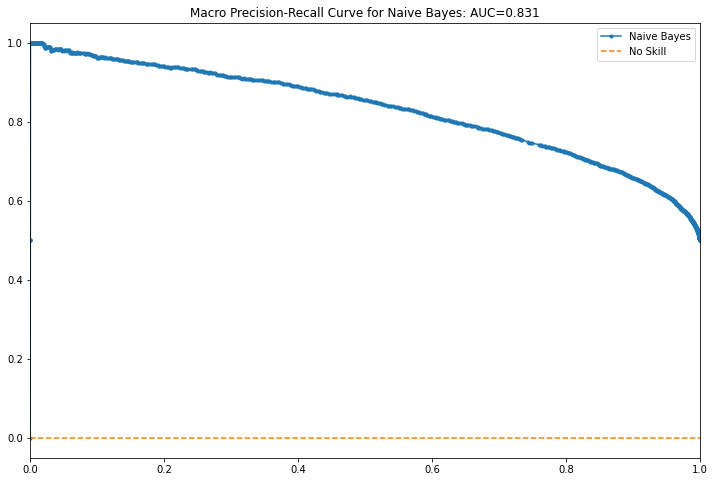

In [0]:
def plot_precision_recall_curve(estimator, estimator_name, X, y_true):
  # predict using given estimator
  y_pred = estimator.predict_proba(X)
  precisions = []
  recalls = []
  
  # thresholds list
  thres = np.linspace(0,1,1000)

  # keep scores for each threshold
  for t in thres:
    prec_dict, rec_dict, _ = get_scores(y_true, y_pred, t)

    precisions.append(prec_dict['macro'])
    recalls.append(rec_dict['macro'])

  # calculate area-under-curve
  area = auc(recalls, precisions)

  # plot
  fig, ax = plt.subplots(figsize=(12,8))
  ax.set_title('Macro Precision-Recall Curve for %s: AUC=%0.3f' % (estimator_name,area))
  ax.plot(recalls, precisions, marker='.', label=estimator_name)
  ax.plot(thres,np.zeros(len(thres)), linestyle='--', label='No Skill')
  ax.set_xlim(0,1)
  ax.legend()
  fig.savefig(str(estimator_name)+"_PR_CURVE.pdf")


pipeline_list = [
                [sgd_pipeline,'SGD']
               ,[rf_pipeline,'Random Forest']
               ,[nb_pipeline,'Naive Bayes']
               ]

for pipe in pipeline_list:
  pipe[0].fit(train_set.text, train_set.sentiment.to_list())
  plot_precision_recall_curve(pipe[0], pipe[1], test_set.text, test_set.sentiment.to_list())

#### Learning Curves

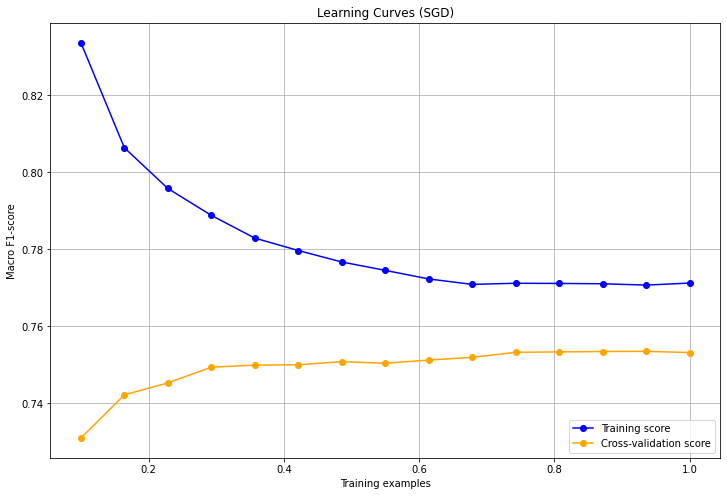

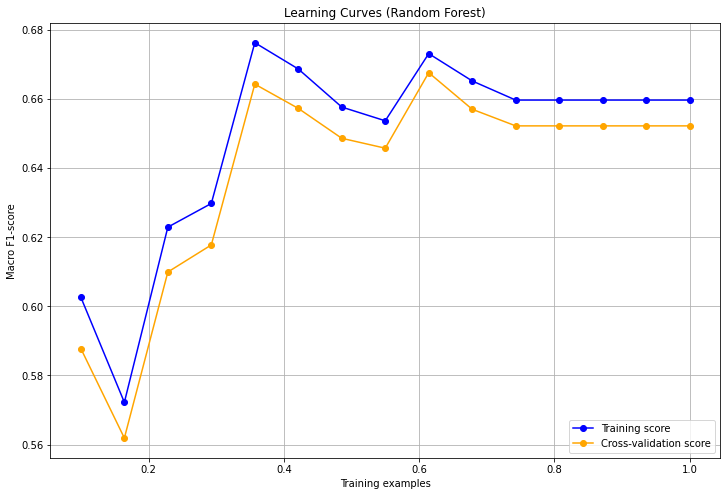

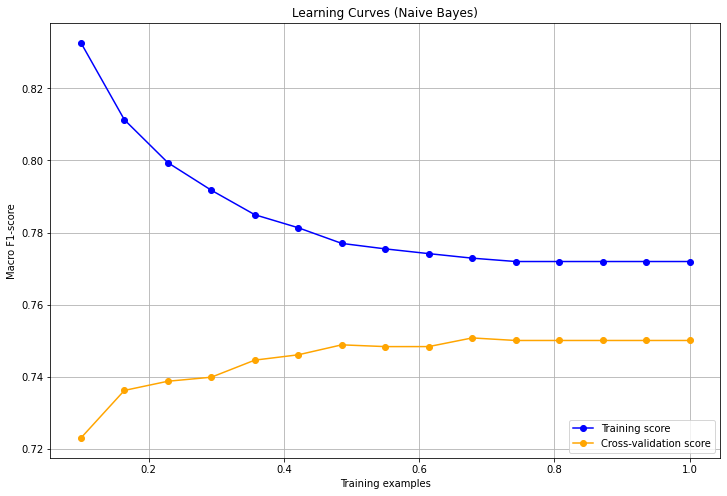

In [0]:
def plot_learning_curve(estimator, title, X, y, X_dev, y_dev, ylim=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
  fig, ax = plt.subplots(figsize=(12,8))
  ax.set_title(title)
  if ylim is not None:
    ax.set_ylim(*ylim)
  ax.set_xlabel("Training examples")
  ax.set_ylabel("Macro F1-score")

  f1_train = []
  f1_dev = []

  # for each training subset, fit and predict
  for t_sz in train_sizes:
    X_subset = X[:int(t_sz * total_length)]
    y_subset = y[:int(t_sz * total_length)]


    estimator.fit(X_subset, y_subset)
      
    y_pred = estimator.predict_proba(X_subset)
    y_pred_dev = estimator.predict_proba(X_dev)

    _, _, f1_dict = get_scores(y_subset, y_pred, 0.5)
    _, _, f1_dict_dev = get_scores(y_dev, y_pred_dev, 0.5)
    f1_train.append(f1_dict['macro'])
    f1_dev.append(f1_dict_dev['macro'])

  ax.grid()
  ax.plot(train_sizes, f1_train, 'o-', color="b",
            label="Training score")
  ax.plot(train_sizes, f1_dev, 'o-', color="orange",
            label="Cross-validation score")

  ax.legend(loc="lower right")
  fig.savefig(title+'.pdf')

for pipe in pipeline_list:
  title = "Learning Curves ("+str(pipe[1])+")"
  plot_learning_curve(pipe[0], title
                    , train_set.text, train_set.sentiment.to_list()
                    , dev_set.text, dev_set.sentiment.to_list()
                    , train_sizes=np.linspace(.1, 1.0, 15)
                    )

#### Bootstrap Statistical Significance Tests

In [0]:
# Initialize classifiers ##########################################
# Base
base_pipeline.fit(train_set.text, train_set.sentiment.to_list())
y_pred = base_pipeline.predict_proba(test_set.text)
_, _, bs_f1 = get_scores(test_set.sentiment.to_list(), y_pred, 0.5)
print('Base macro-f1: {:.4f}'.format( bs_f1['macro']))

# SGD
sgd_pipeline.fit(train_set.text, train_set.sentiment.to_list())
y_pred = sgd_pipeline.predict_proba(test_set.text)
_, _, sgd_f1 = get_scores(test_set.sentiment.to_list(), y_pred, 0.5)
print('SGD macro-f1: {:.4f}'.format(sgd_f1['macro']))

# RF
rf_pipeline.fit(train_set.text, train_set.sentiment.to_list())
y_pred = rf_pipeline.predict_proba(test_set.text)
_, _, rf_f1 = get_scores(test_set.sentiment.to_list(), y_pred, 0.5)
print('RF macro-f1: {:.4f}'.format( rf_f1['macro']))

# NB
nb_pipeline.fit(train_set.text, train_set.sentiment.to_list())
y_pred = nb_pipeline.predict_proba(test_set.text)
_, _, nb_f1 = get_scores(test_set.sentiment.to_list(), y_pred, 0.5)
print('NB macro-f1: {:.4f}'.format( nb_f1['macro']))


# Bootstrapping significance test ###################################

def bootstrap_sign_test(best_estimator, comp_estimator, dataset, b, N):
  """
  Input:
    best_estimator: best scoring pipeline in terms of macro-f1
    comp_estimator: pipeline to be compared with the best
    b: number of sampling datasets
    N: size of sampling datasets

  Output:
    p_value: p-value for the bootstrapping significance test
  """
  y1 = best_estimator.predict_proba(dataset.text)
  _, _, e1_f1 = get_scores( dataset.sentiment.to_list(), y1, 0.5)

  y2 = comp_estimator.predict_proba(dataset.text)
  _, _, e2_f1 = get_scores( dataset.sentiment.to_list(), y2, 0.5)
  
  # calculate true difference
  delta = e1_f1['macro'] - e2_f1['macro']

  diffs = []

  # calculate a diff for each simulated sample dataset
  for i in range(b):
    bootstrap = dataset.sample(replace = True, n = N)
    y_best = best_estimator.predict_proba( bootstrap.text )
    y_comp = comp_estimator.predict_proba( bootstrap.text )

    _, _, best_f1 = get_scores(bootstrap.sentiment.to_list(), y_best, 0.5)
    _, _, comp_f1 = get_scores(bootstrap.sentiment.to_list(), y_comp, 0.5)
    diffs.append(best_f1['macro'] - comp_f1['macro'])
  
  # calculate p-value
  s = 0
  for i in range(b):
    if diffs[i] > 2 * delta:
      s += 1
  p_value = s/b
  
  return p_value

# print p-values
start_time = time.time()

print('SGD vs BASE, p_value:  {:.4f}' .format( bootstrap_sign_test(sgd_pipeline, base_pipeline, test_set, b = 1000, N = 1000) ))
print('SGD vs Naive, p_value: {:.4f}' .format( bootstrap_sign_test(sgd_pipeline, nb_pipeline, test_set, b = 1000, N = 1000) ))
print('SGD vs Random Forest, p_value: {:.4f}' .format( bootstrap_sign_test(sgd_pipeline, rf_pipeline, test_set, b = 1000, N = 1000) ))

elapsed_time = time.time() - start_time

print('Elapsed time {:.0f} seconds'.format(elapsed_time))

Base macro-f1: 0.3356
SGD macro-f1: 0.7559
RF macro-f1: 0.6502
NB macro-f1: 0.7460
SGD vs BASE, p_value:  0.0000
SGD vs Naive, p_value: 0.1820
SGD vs Random Forest, p_value: 0.0000
Elapsed time 300 seconds


#### Appendix Α -  Dimensionality Reduction


In [0]:
# append SVD dimensionality reduction as a second step
sgd_pipeline.steps.insert(1,('tfidf_svd', TruncatedSVD(n_components=500, random_state=94))) #insert as second step

start_time = time.time()
sgd_pipeline.fit(train_set.text, train_set.sentiment.to_list())
elapsed_time = time.time() - start_time
print('Fitting ended after {:.0f} seconds.'.format(elapsed_time))

print_classifier_scores(sgd_pipeline, 'SGD classifier', train_set.text, train_set.sentiment.to_list()
  , dev_set.text, dev_set.sentiment.to_list()
  , test_set.text, test_set.sentiment.to_list(),0.5)

Fitting ended after 30 seconds.
SGD classifier- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.694 |    0.813 | 0.749 |
| 1     |       0.772 |    0.639 | 0.699 |
| macro |       0.733 |    0.726 | 0.724 |
+-------+-------------+----------+-------+
---------------------------------------------------------
SGD classifier- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.682 |    0.81  | 0.74  |
| 1     |       0.768 |    0.625 | 0.689 |
| macro |       0.725 |    0.717 | 0.715 |
+-------+-------------+----------+-------+
---------------------------------------------------------
SGD classifier- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.688 |    0.81  |

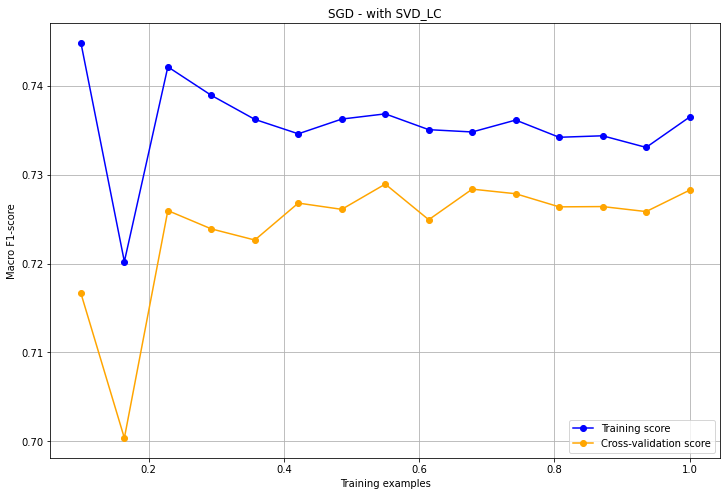

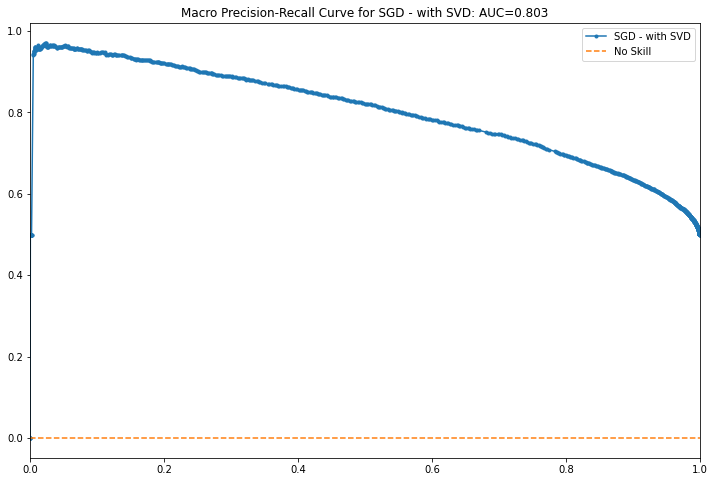

In [0]:
start_time = time.time()
# Learning curve
plot_learning_curve(sgd_pipeline, 'SGD - with SVD_LC'
                    , train_set.text, train_set.sentiment.to_list()
                    , dev_set.text, dev_set.sentiment.to_list()
                    , train_sizes=np.linspace(.1, 1.0, 15)
                    )
# Precision Recall curve
plot_precision_recall_curve(sgd_pipeline, 'SGD - with SVD_RC', test_set.text, test_set.sentiment.to_list())

elapsed_time = time.time() - start_time

print('Elapsed time {:.0f} seconds'.format(elapsed_time))

#### Appendix Β- Word Embeddings

In [1]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-05-27 13:39:57--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.144.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.144.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.5MB/s    in 98s     

2020-05-27 13:41:36 (16.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
from gensim.models.keyedvectors import KeyedVectors
import os
import gzip
import shutil, sys  

#Centroids of Word Embeddings

def extract_embeddings():
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        print('File "GoogleNews-vectors-negative300.bin" already exists!')
        return
    print('Extracting...')
    with gzip.open('GoogleNews-vectors-negative300.bin.gz', 'r') as f_in, open('GoogleNews-vectors-negative300.bin', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
    print('File extracted.')

def load_embeddings(fname, vocab):
    model = KeyedVectors.load_word2vec_format(fname, binary=True)
    dim = model.vectors.shape[1]
    embeddings = np.zeros((len(vocab), dim))

    for word in vocab:
        if word in model:
            embeddings[vocab[word]] = model[word]
        else:
            embeddings[vocab[word]] = np.random.uniform(-0.25, 0.25, dim)
    return embeddings

def EmbeddingMeanVectorizer(docs, model):
    dim = model.shape[1]
    tweetvec = np.zeros((len(docs), dim))
    for i, doc in enumerate(docs):
        sent_vec = np.zeros(dim)
        numw = 0
        for w in doc.split():
            try:
                sent_vec = np.add(sent_vec, model[vectorizer.vocabulary_[w]])
                numw += 1
            except:
                pass
        tweetvec[i] = sent_vec/numw
    return tweetvec

In [5]:
extract_embeddings()

Extracting...
File extracted.


In [20]:
np.seterr(divide='ignore', invalid='ignore')
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
vectorizer.fit(train_set.text)
vectorizer.fit(dev_set.text)
vectorizer.fit(test_set.text)
embeddings = load_embeddings('GoogleNews-vectors-negative300.bin', vectorizer.vocabulary_)

X_train = EmbeddingMeanVectorizer(train_set.text, embeddings)
X_dev = EmbeddingMeanVectorizer(dev_set.text, embeddings)
X_test = EmbeddingMeanVectorizer(test_set.text, embeddings)

X_train = np.nan_to_num(X_train)
X_dev = np.nan_to_num(X_dev)
X_test = np.nan_to_num(X_test)

y_train_true = train_set.sentiment.tolist()
y_dev_true = dev_set.sentiment.tolist()
y_test_true = test_set.sentiment.tolist()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [23]:
grid_params = {
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}
# start timing
start_time = time.time()
sgd_clf = SGDClassifier(loss="log", penalty='l1', max_iter=5000, alpha=0.0001)
grid_sgd_clf = RandomizedSearchCV(sgd_clf, grid_params, scoring='f1_macro',n_jobs=-1, random_state=94)

# perform gridsearch on both training and dev set with 5-fold cross validation and save the best model
grid_sgd_clf.fit(X_train, y_train_true)

elapsed_time = time.time() - start_time
sgd_clf = grid_sgd_clf.best_estimator_

sgd_clf.fit(X_train, y_train_true)

print_classifier_scores(sgd_clf, 'SGD classifier with word embeddings', X_train, y_train_true
  , X_dev, y_dev_true
  , X_test, y_test_true,0.5)

SGD classifier with word embeddings- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.728 |    0.774 | 0.75  |
| 1     |       0.757 |    0.71  | 0.733 |
| macro |       0.743 |    0.742 | 0.741 |
+-------+-------------+----------+-------+
---------------------------------------------------------
SGD classifier with word embeddings- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.726 |    0.776 | 0.75  |
| 1     |       0.76  |    0.707 | 0.733 |
| macro |       0.743 |    0.742 | 0.741 |
+-------+-------------+----------+-------+
---------------------------------------------------------
SGD classifier with word embeddings- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0